In [1]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.ticker import MaxNLocator

from pathlib import Path
plt.style.use('seaborn-colorblind')

# 3x3 Prediction vs Reference Scatterplot

In [2]:
# Model directory / Network architecture
model_dir1 = "SuperResolution"
model_dir2 = "Surrogate"

# Define the range of the time series
var = {0: "Hs", 1: "Tm02", 2: "Dir"}

# Define the points where the time series are extracted (in pixel)
xi = [69, 86, 69]
yi = [94, 104, 77] 

# Computer number of extraction points for easier acess
npts = len(xi)

# Save the figure?
save = True

In [3]:
def compute_stats(prediction, HR):
    # Bias
    bias = np.nanmean(HR - prediction)
    # RMSE 
    rmse = np.sqrt(np.nanmean((HR - prediction)**2))
    # SI
    nrmse = rmse/np.nanmean(HR)*100  # Show it in percent
    
    return bias, rmse, nrmse


def load_time_series(variable, model_dir, xi, yi):
    path_dir = Path(f"Data/Time_Series/{model_dir}")
    path_arr = path_dir / f"Var_{variable}_posxy_{xi}_{yi}.npy"

    arr = np.load(path_arr)

    prediction = arr[0, :]
    HR = arr[1, :]
    LR = arr[2, :]
    
    return prediction, HR, LR

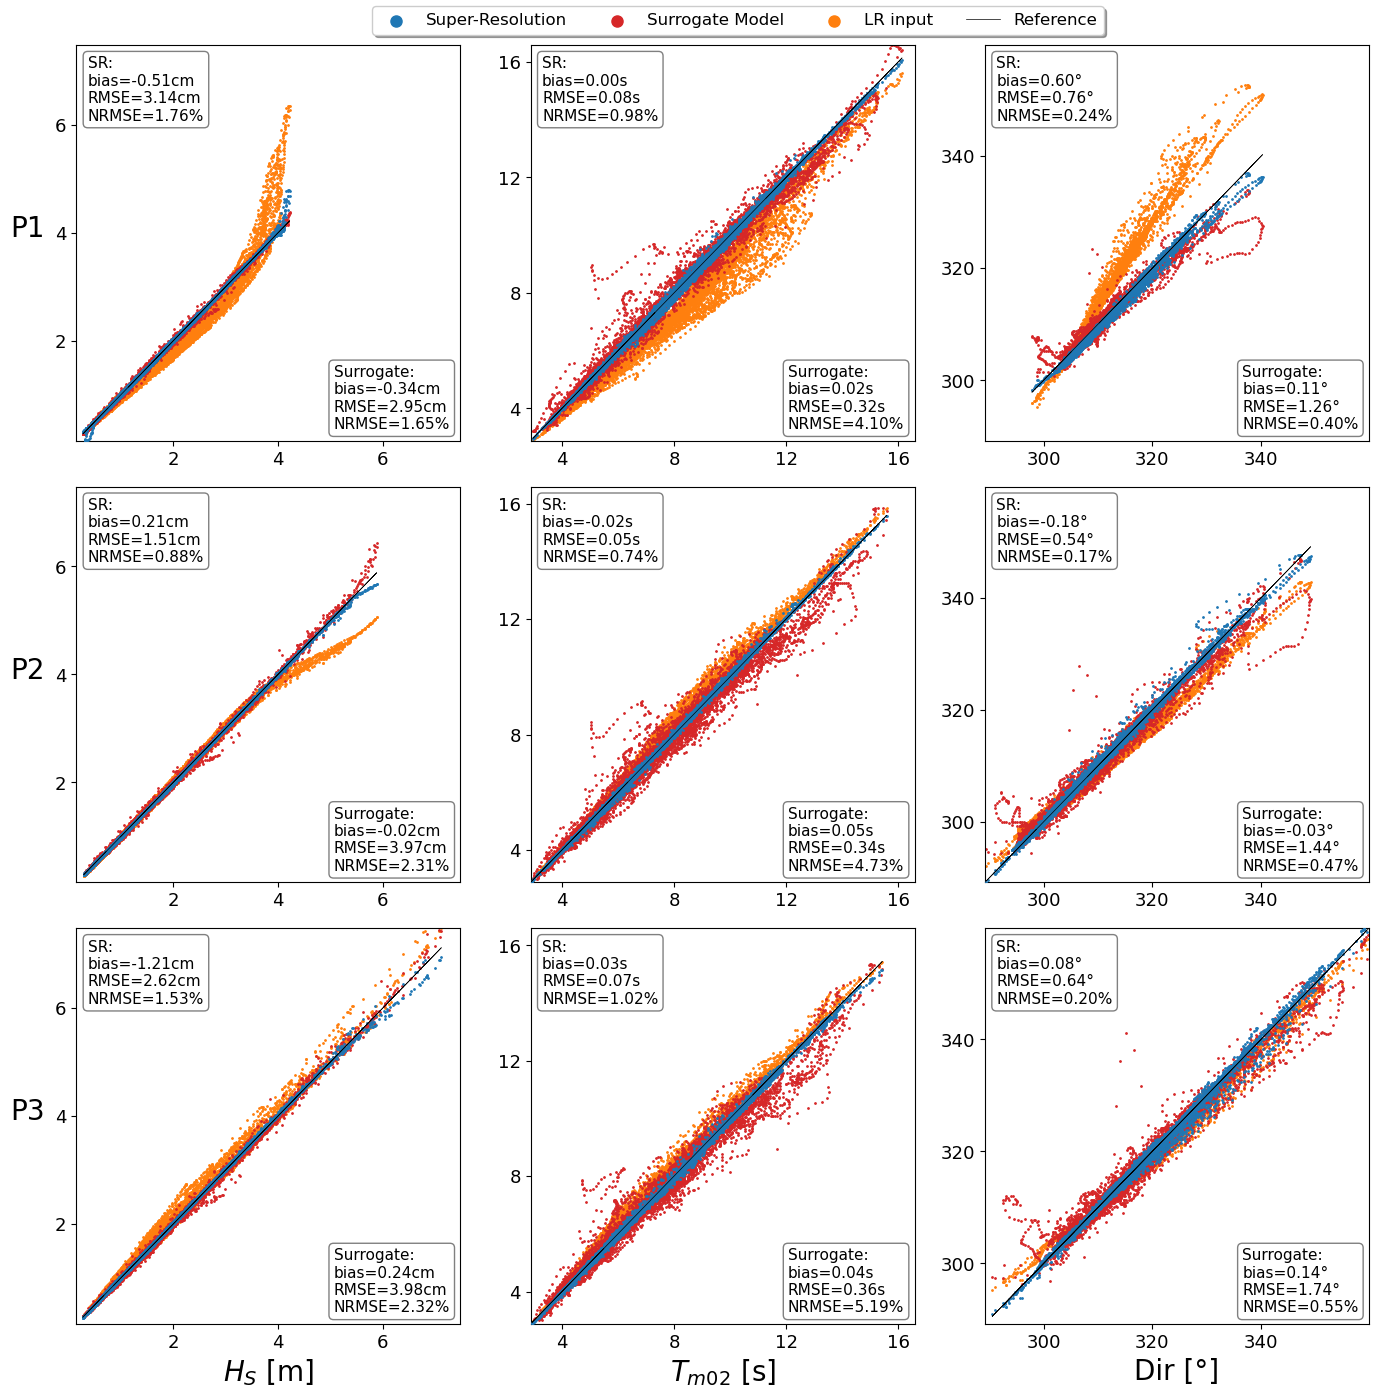

In [4]:
# Constants to easily change font sizes
LABELSIZE = 20
TICKLABELSIZE = 13
LEGENDFONTSIZE = 12
TITLESIZE = 15
TEXTSIZE = 11

# Various plot labels
xlabel = {0: r"$H_S$ ", 1: r"$T_{m02}$ ", 2: r"Dir "}
units = {0: "[m]", 1: "[s]", 2: "[°]"}
lunits = {0: "cm", 1: "s", 2: "°"}  # Show stats in cm, s, and °
factors = [100, 1, 1]  # Multiply Hs MAE times 100 to get cm

label1 = "Super-Resolution"
label2 = "Surrogate Model"
label3 = "LR input"
label4 = "Reference"
labels = [label1, label2, label3, label4]

fig, axs = plt.subplots(3, 3, figsize=(14, 14)) # , sharex="col", sharey="col")

for nvar in range(len(var)):
    # Determine max- and minval for each column to determine axis limits
    min_val = np.infty
    max_val = -np.infty
    for npt in range(npts):
        prediction1, HR, LR = load_time_series(var[nvar], model_dir1,
                                               xi[npt], yi[npt])
        prediction2, _, _ = load_time_series(var[nvar], model_dir2,
                                             xi[npt], yi[npt])

        # Compute and plot statistics for super-resolution
        bias, rmse, nrmse = compute_stats(prediction1, HR)
        
        text = "\n".join([fr"SR:",
                          f"bias={bias*factors[nvar]:.2f}{lunits[nvar]}",
                          f"RMSE={rmse*factors[nvar]:.2f}{lunits[nvar]}",
                          f"NRMSE={nrmse:.2f}%"]) 
        textbox = axs[npt, nvar].annotate(text, (0.03, 0.81), xycoords="axes fraction",
                                          fontsize=TEXTSIZE, bbox=dict(boxstyle="round",
                                                                       facecolor='none',
                                                                       edgecolor="grey"))
        
        # Compute and plot statistics for surrogate model
        bias, rmse, nrmse = compute_stats(prediction2, HR)
        
        text = "\n".join([fr"Surrogate:",
                          f"bias={bias*factors[nvar]:.2f}{lunits[nvar]}",
                          f"RMSE={rmse*factors[nvar]:.2f}{lunits[nvar]}",
                          f"NRMSE={nrmse:.2f}%"]) 
        textbox = axs[npt, nvar].annotate(text, (0.67, 0.03), xycoords="axes fraction",
                                          fontsize=TEXTSIZE, bbox=dict(boxstyle="round",
                                                                       facecolor='none',
                                                                       edgecolor="grey"))
        
        
        # Draw the scatter plots
        line1 = axs[npt, nvar].scatter(HR, prediction1, s=1, label=label1,
                                       color="tab:blue", zorder=3)
        line2 = axs[npt, nvar].scatter(HR, prediction2, s=1, label=label2,
                                       color="tab:red", zorder=2)
        line3 = axs[npt, nvar].scatter(HR, LR, s=1, label=label3,
                                       color="tab:orange", zorder=1)
        line4, = axs[npt, nvar].plot(HR, HR, '-k', linewidth=0.5, label=label4, zorder=5)
        
        axs[npt, nvar].tick_params(axis='both', labelsize=TICKLABELSIZE)
        
        axs[npt, 0].set_ylabel(f"P{npt+1}", size=LABELSIZE, rotation=0, labelpad=20)
        axs[2, nvar].set_xlabel(xlabel[nvar] + units[nvar], size=LABELSIZE)
        
        # Determine x-, and y-limits for each column
        max_val_cur = max(np.nanmax(LR), np.nanmax(prediction1),
                          np.nanmax(prediction2), np.nanmax(HR))
        min_val_cur = min(np.nanmin(LR), np.nanmin(prediction1),
                          np.nanmin(prediction2), np.nanmin(HR))
        
        if max_val < max_val_cur:
            max_val = max_val_cur
        if min_val > min_val_cur:
            min_val = min_val_cur        
        
    # Maximum 5 ticks, set at nice locations
    locations = MaxNLocator(4).tick_values(min_val, max_val).astype(np.int32)
    # Set same ticklabels for both x- and y-axis
    axs[0, nvar].set_xticks(locations)
    axs[0, nvar].set_xticklabels(locations)
    axs[0, nvar].set_yticks(locations)
    axs[0, nvar].set_yticklabels(locations)

    axs[1, nvar].set_xticks(locations)
    axs[1, nvar].set_xticklabels(locations)
    axs[1, nvar].set_yticks(locations)
    axs[1, nvar].set_yticklabels(locations)
        
    axs[2, nvar].set_xticks(locations)
    axs[2, nvar].set_xticklabels(locations)
    axs[2, nvar].set_yticks(locations)
    axs[2, nvar].set_yticklabels(locations)

    axs[0, nvar].set_xlim(min_val, max_val)
    axs[0, nvar].set_ylim(min_val, max_val)

    axs[1, nvar].set_xlim(min_val, max_val)
    axs[1, nvar].set_ylim(min_val, max_val)

    axs[2, nvar].set_xlim(min_val, max_val)
    axs[2, nvar].set_ylim(min_val, max_val)

handles = [line1, line2, line3, line4]
fig.legend(handles, labels, loc=[0.27, 0.975], markerscale=8,
           fancybox=True, shadow=True, ncol=4, fontsize=LEGENDFONTSIZE)

plt.tight_layout()

fig.subplots_adjust(top=0.97)


# Output folder and file name
fdir = Path("Plots")
fname = f"ReferenceVsPrediction.png"

if save:
    if not fdir.exists():
        fdir.mkdir()
    plt.savefig(fdir / fname)
    
plt.show()